<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/UnetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!rm -rf *

Thu Oct 22 01:44:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1"
!mv "ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1" "DRIVE.rar"
!unrar x DRIVE.rar
!rm "DRIVE.rar"

--2020-10-22 01:44:50--  https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ERgktnjHms9DroR01IFSAsEBGQipq3SG8sjTZUSEQuRK9Q?download=1
Resolving correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)... 13.107.136.9
Connecting to correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/DRIVE.rar?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FUmdrdG5qSG1zOURyb1IwMUlGU0FzRUJHUWlwcTNTRzhzalRaVVNFUXVSSzlRP3J0aW1lPWV6clZFQ3gyMkVn [following]
--2020-10-22 01:44:50--  https://correoipn-my.sharepoint.com/personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/DRIVE.rar?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FUmdrdG5qSG

In [3]:
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/EeJjVR695xFMiVlTmZRPDh8BgZzjgU81MtJbNeyD3GyLQw?download=1"
!mv "EeJjVR695xFMiVlTmZRPDh8BgZzjgU81MtJbNeyD3GyLQw?download=1" STARE.zip
!unzip STARE.zip
!rm STARE.zip

--2020-10-22 01:44:52--  https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/EeJjVR695xFMiVlTmZRPDh8BgZzjgU81MtJbNeyD3GyLQw?download=1
Resolving correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)... 13.107.136.9
Connecting to correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/STARE.zip?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FZUpqVlI2OTV4Rk1pVmxUbVpSUERoOEJnWnpqZ1U4MU10SmJOZXlEM0d5TFF3P3J0aW1lPWZJci1FU3gyMkVn [following]
--2020-10-22 01:44:52--  https://correoipn-my.sharepoint.com/personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/STARE.zip?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FZUpqVlI2OT

In [4]:
!git clone --depth 1 https://github.com/Vengadore/Segmentation_OPTOS.git

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


## Load Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import os

In [2]:
path = "./"
os.listdir(path)

['.config',
 'Modelo_seg.ph',
 'training',
 'test',
 'test_2ndmanual.csv',
 'training.csv',
 'Modelo_seg(1).ph',
 'Segmentation_OPTOS',
 'STARE',
 'test_1stmanual.csv']

In [3]:
data = pd.read_csv(os.path.join(path,'training.csv'))
data_test = pd.read_csv(os.path.join(path,'test_1stmanual.csv'))
data.head()

,Original,GroundTruth
0,21_training.tif,21_manual1.tif
1,22_training.tif,22_manual1.tif
2,23_training.tif,23_manual1.tif
3,24_training.tif,24_manual1.tif
4,25_training.tif,25_manual1.tif


In [4]:
data['Original'] = data['Original'].apply(lambda x:os.path.join(path,"training/images/"+x))
data['GroundTruth'] = data['GroundTruth'].apply(lambda x:os.path.join(path,"training/1st_manual/"+x))
data.head()

,Original,GroundTruth
0,./training/images/21_training.tif,./training/1st_manual/21_manual1.tif
1,./training/images/22_training.tif,./training/1st_manual/22_manual1.tif
2,./training/images/23_training.tif,./training/1st_manual/23_manual1.tif
3,./training/images/24_training.tif,./training/1st_manual/24_manual1.tif
4,./training/images/25_training.tif,./training/1st_manual/25_manual1.tif


In [5]:
data_test['Original'] = data_test['Original'].apply(lambda x:os.path.join(path,"test/images/"+x))
data_test['GroundTruth'] = data_test['GroundTruth'].apply(lambda x:os.path.join(path,"test/1st_manual/"+x))
data.head()

,Original,GroundTruth
0,./training/images/21_training.tif,./training/1st_manual/21_manual1.tif
1,./training/images/22_training.tif,./training/1st_manual/22_manual1.tif
2,./training/images/23_training.tif,./training/1st_manual/23_manual1.tif
3,./training/images/24_training.tif,./training/1st_manual/24_manual1.tif
4,./training/images/25_training.tif,./training/1st_manual/25_manual1.tif


In [6]:
Data_stare = pd.read_csv('./STARE/Data.csv')
Data_stare['Original'] = Data_stare['Original'].apply(lambda x:os.path.join(path,"STARE/Original/"+x))
Data_stare['GroundTruth'] = Data_stare['GroundTruth'].apply(lambda x:os.path.join(path,"STARE/GroundTruth/"+x))
Data_stare.head()

,Original,GroundTruth
0,./STARE/Original/im0001.ppm,./STARE/GroundTruth/im0001.vk.ppm
1,./STARE/Original/im0002.ppm,./STARE/GroundTruth/im0002.vk.ppm
2,./STARE/Original/im0003.ppm,./STARE/GroundTruth/im0003.vk.ppm
3,./STARE/Original/im0004.ppm,./STARE/GroundTruth/im0004.vk.ppm
4,./STARE/Original/im0005.ppm,./STARE/GroundTruth/im0005.vk.ppm


In [7]:
data = data.append(Data_stare).reset_index()
data = data[['Original','GroundTruth']]

In [12]:
## Resize training images
import os
import cv2
for i in data['Original']:
  I = cv2.imread(i)
  (M,N,C) = I.shape
  I = cv2.resize(I,(int(N/M*584*4), 584*4),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)

for i in data['GroundTruth']:
  I = cv2.imread(i)
  (M,N,C) = I.shape
  I = cv2.resize(I,(int(N/M*584*4), 584*4),cv2.INTER_NEAREST)
  thresh,I = cv2.threshold(I,127,255,cv2.THRESH_BINARY)
  I = cv2.imwrite(i,I)

In [13]:
#Resize Test_images
for i in data_test['Original']:
  I = cv2.imread(i)
  (M,N,C) = I.shape
  I = cv2.resize(I,(int(N/M*584*4), 584*4),cv2.INTER_CUBIC)
  I = cv2.imwrite(i,I)

for i in data_test['GroundTruth']:
  I = cv2.imread(i)
  (M,N,C) = I.shape
  I = cv2.resize(I,(int(N/M*584*4), 584*4),cv2.INTER_NEAREST)
  thresh,I = cv2.threshold(I,127,255,cv2.THRESH_BINARY)
  I = cv2.imwrite(i,I)

## Creation of dataloader

In [8]:
from Segmentation_OPTOS.Tools.Generators import Patch_generator
import cv2

In [9]:
def x_trans(X):
    #X = cv2.resize(X,(584*2, 565*2),cv2.INTER_CUBIC)
    #mean,std = cv2.meanStdDev(X)
    #_,_,C = X.shape
    #for i in range(C):
    #    X[:,:,i] = (X[:,:,i]-mean[i])/std[i]
    ## Change order of channels
    X = X.transpose(2,0,1)
    return X

def y_trans(X):
    # Change order of channels
    #X = cv2.resize(X,(584*3, 565*3),cv2.INTER_CUBIC)
    X = X.transpose(2,0,1)
    X = np.expand_dims(X[0,:,:],axis = 0)
    return X

Training_patches = Patch_generator.Generator_from_DataFrame(data,patch_size=(127,127),X = 'Original',
                                                   y = "GroundTruth",n_patches = 20,transforX=x_trans,transfory=y_trans)

Validation_patches = Patch_generator.Generator_from_DataFrame(data,patch_size=(127,127),X = 'Original',
                                                   y = "GroundTruth",n_patches = 20,transforX=x_trans,transfory=y_trans)

40 files found out of 40 in the DataFrame for X
40 files found out of 40 in the DataFrame for y
A generator object has been created with 20 per image
40 files found out of 40 in the DataFrame for X
40 files found out of 40 in the DataFrame for y
A generator object has been created with 20 per image


## Definition of the network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = nn.Conv2d(3,256,(3,3),stride = (1,1),padding=(1,1))
        self.norm1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256,128,(3,3),stride = (1,1),padding=(1,1))
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,64,(3,3),stride = (1,1),padding=(1,1))
        self.norm3 = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d((2,2))
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.norm1(x)
        x = F.relu(self.conv2(x))
        x = self.norm2(x)
        x = F.relu(self.conv3(x))
        x = self.norm3(x)
        x = self.max_pool(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1T = nn.ConvTranspose2d(64,64,(3,3),padding=(1,1))
        self.conv2T = nn.ConvTranspose2d(64,64,(3,3),stride=(2,2),padding=(1,1))
        self.conv3T = nn.ConvTranspose2d(64,128,(3,3),padding=(1,1))
        self.conv4T = nn.ConvTranspose2d(128,256,(3,3))
        self.conv5T = nn.ConvTranspose2d(256,1,(1,1))
    def forward(self,x):
        x = F.relu(self.conv1T(x))
        x = F.relu(self.conv2T(x))
        x = F.relu(self.conv3T(x))
        x = F.relu(self.conv4T(x))
        x = torch.sigmoid(self.conv5T(x))
        return x
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self,x):
        x = self.encoder.forward(x)
        x = self.decoder.forward(x)
        return x

In [12]:
model = Model()

In [13]:
# Load Pretrained Model
model = torch.load("./Modelo_seg.ph")

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [15]:
model = model.to(device)

In [61]:
63*63*80*len(data)

12700800

## Train Network

In [56]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.000005)

In [ ]:
for epoch in range(50000):  # loop over the dataset multiple times
    running_loss = 0.0
    ## Training loop for epoch
    Accuracy = 0.0
    for i in range(len(data)):
        (X,y) = next(Training_patches)
        X = torch.FloatTensor(X).to(device)
        y = torch.FloatTensor(y).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, y)
        #train_acc = torch.sum(torch.gt(outputs, 0.5) == torch.gt(y, 0.5))
        loss.backward()
        optimizer.step()
        
        # Accuracy
        #Accuracy += np.sum(np.max(y.detach().cpu().numpy()) == np.max(outputs.detach().cpu().numpy()))
        # print statistics
        running_loss += loss.item()
    print(f"Epoch:{epoch+1} Loss:{running_loss} ")#Accuracy = {Accuracy/6350400}")

print('Finished Training')

Epoch:1 Loss:5.33868807926774 
Epoch:2 Loss:4.627250581979752 
Epoch:3 Loss:4.865244470536709 
Epoch:4 Loss:4.765494503080845 
Epoch:5 Loss:4.647200010716915 
Epoch:6 Loss:4.883049476891756 
Epoch:7 Loss:4.83039840310812 
Epoch:8 Loss:4.702950097620487 
Epoch:9 Loss:5.054580807685852 
Epoch:10 Loss:4.777586732059717 
Epoch:11 Loss:4.7873909287154675 
Epoch:12 Loss:4.800771027803421 
Epoch:13 Loss:4.8094498962163925 
Epoch:14 Loss:5.1446802765131 


AttributeError: ignored

In [46]:
torch.save(model,"Modelo_seg.ph")

In [ ]:
model = torch.load('Modelo_seg.ph')

In [21]:
from Segmentation_OPTOS.Tools.Generators.Patch_generator import Image2Generator,Generator2ImagePT

In [47]:
I = cv2.imread(data_test['Original'].iloc[-2])
I.shape

(2336, 2260, 3)

In [48]:
Test_generator = Image2Generator(I,patch_size=[63,63],batch_size=1)

A generator object containing all the image has been created


In [49]:
New_I = Generator2ImagePT(model,Test_generator)

In [50]:
New_I.shape

(2336, 2260)

In [51]:
New_I.max()

1.0

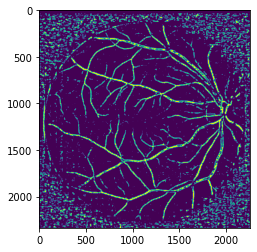

In [52]:
plt.imshow(New_I>0.6)

In [42]:
plt.imsave("Example.jpeg",New_I)

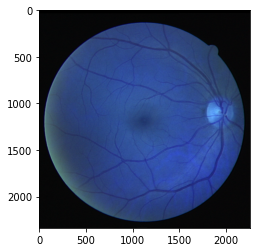

In [43]:
plt.imshow(I)